## Notebook for Figure 4

In [1]:
%matplotlib inline

from tqdm.notebook import tqdm
import os 
import requests

import xarray as xr
import numpy as np 

# importing the TDigest package
from crick import TDigest

#Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.patches as patches
import cartopy.crs as ccrs

from one_pass.opa import Opa

Load data and extract wind speed. 

The wind speed has been calculated using the square root of the sum of the two horizontal wind components from the IFS model, run as part of the nextGEMS cycle 3 runs.

Showing hourly data over December 2020.

We have re-sampled the data down to r100 for usabiltiy: this allows us to demonstrate the streaming algorithms by loading all the data in memory and then looping through.

In operational mode this would done via an automated workflow manager or similar that would pass higher resolution data to the algorithms chunk by chunk.

In [2]:
# Download data if not present

URLS = {
    "ws_2020.nc": "https://zenodo.org/records/12533197/files/wind_speed_dec_2020_IFS_tco2559_ng5_cycle3_r100.nc?download=1",
    "ws_2020_texas.nc": "https://zenodo.org/records/12533197/files/wind_speed_dec_texas_IFS_tco2559_ng5_cycle3_r010.nc?download=1",
    "ws_2020_uk.nc": "https://zenodo.org/records/12533197/files/wind_speed_dec_uk_IFS_tco2559_ng5_cycle3_r010.nc?download=1",
}

def read_or_download(filename: str, data_array=False):
    url = URLS[filename]
    if not os.path.isfile(filename):
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        else:
            print(f"Failed to download file. Status code: {response.status_code}")
    return xr.open_dataset(filename)

ws = read_or_download("ws_2020.nc")["wind_speed_rms_u10_v10"]
ws_texas = read_or_download("ws_2020_texas.nc").to_dataarray().data
ws_uk = read_or_download("ws_2020_uk.nc").to_dataarray().data

Here we run the functions 'init_digests' and 'update_digests' that creates digests for the streamed data and adds the new data chunks to the digests. We use a weight of 4 for each data chunk.

In [3]:
# extract data array

step = 4
n = 0

# inside the package this calculated based on the time stamp of the incoming data and the
# time step of the data, however here just setting it for convienece
c = len(ws.time)

opa_stat = Opa({
    "variable": "wind_speed_rms_u10_v10",
    "stat": "percentile",
    "percentile_list": [],
    "stat_freq": "monthly",
    "output_freq": "monthly",
    "time_step": 60,  # minutes
    "checkpoint": False,
    "save": False,
})

# simulating the streamed data
for hour in tqdm(range(0, c, step)):

    incoming_data_chunk = ws.isel(time = slice(hour, hour+step))
    res = opa_stat.compute(incoming_data_chunk)

size_data_source_tail = np.size(incoming_data_chunk.tail(time=1))

  0%|          | 0/186 [00:00<?, ?it/s]

We now want to calculate the estimated value of each percentile from using the t-digest comapred to the estimate from using numpy. 

Here we calculate the numpy estimate for every percentile value over the spatial grid (we flatten the array to match the shape of the digest list)

In [4]:
# list of quantiles we want to loop thorugh
quantiles = res.percentile.values * 100
# empty array that will story all the numpy percentile estimates for every grid cell
percen_np = np.zeros([len(quantiles), size_data_source_tail])
# flattening the array over the spatial grid
ws_flat = np.reshape(ws.values, [len(ws.time), size_data_source_tail])
# going through every quantile 
for index, quantile in tqdm(enumerate(quantiles), total=len(quantiles)):
    percen_np[index, :] = np.percentile(ws_flat, axis = 0, q = quantile, method = 'linear')


  0%|          | 0/100 [00:00<?, ?it/s]

Here we calculate the t-dgiest estimate for every percentile value over the spatial grid

We now compare the numpy estimate against the t-dgiest estimate and provide the error as a percentage of the numpy value

In [5]:
percen_opa = res["wind_speed_rms_u10_v10"].values[0, :, :, :].reshape((100, -1))
time_dim, lat_size, lon_size = np.shape(incoming_data_chunk)

per_error = ((percen_opa - percen_np)/percen_np) * 100        

# averaging the error across all the percentiles
average_error = np.mean(abs(per_error), axis = 0)

# reshape array back to lat lon
total_per_error = np.reshape(average_error, [1, lat_size, lon_size])

In [6]:
# Huge

total_per_error

array([[[ 89.57009114,  78.63263436,  72.88379099, ...,  65.79536482,
          66.4965428 ,  67.2003026 ],
        [ 73.88320241,  74.69731021,  74.13690218, ...,  57.22292918,
          57.21823378,  57.38354538],
        [ 60.05580985,  60.29708008,  60.58134468, ..., 101.55920265,
         101.48897716, 103.00528036],
        ...,
        [ 50.85462284,  49.72841116,  52.96463632, ...,  84.63536162,
          88.4526656 ,  94.47176899],
        [160.09468306, 130.30536731, 132.24195734, ...,  66.55922458,
          78.7487285 ,  79.51189912],
        [ 61.7500674 ,  62.46927673,  62.87153311, ..., 149.78494507,
         157.70728787, 168.90091311]]], shape=(1, 180, 360))

Loading the two time series for the Moray East wind farm in the North Sea and the Rosoe wind farm in Texas, North America. These time series were extracted from the native resolution data to be more accurate with the location. If you want to change the location of these points to examine different locations, uncomment the code below (ws_uk or ws_texas) |to select dat from the downsampled dataset

In [7]:
# defining a function to give the closest lat lon indicies based on a target lat lon
def closest_value(input_list, input_value):
  arr = np.asarray(input_list)
  i = (np.abs(arr - input_value)).argmin()
  return arr[i]

Here we match the co-ordinates of the two wind farm locations to their closest location on the overall wind speed dataset to allow for plotting. 

To use data from the downsampled data set, uncomment the ws_uk line

In [8]:
# target lat and lon for the Moray East wind farm
target_lat = 58.25
target_lon = 2.75

target_lon_new = closest_value(ws.lon.values, target_lon)
target_lat_new = closest_value(ws.lat.values, target_lat)

# getting the target index to draw the locations on the global map
target_index_uk_lat = np.where(ws.lat.values == target_lat_new)[0][0]
target_index_uk_lon = np.where(ws.lon.values == target_lon_new)[0][0]

# ws_uk = ds.wind_speed_rms_u10_v10[:, target_index_uk_lat, target_index_uk_lon]


In [9]:
# target lat and lon for the Roscoe wind farm
target_lat = 32.35
target_lon = 360-100.55

target_lon_new = closest_value(ws.lon.values, target_lon)
target_lat_new = closest_value(ws.lat.values, target_lat)

target_index_texas_lat = np.where(ws.lat.values == target_lat_new)[0][0]
target_index_texas_lon = np.where(ws.lon.values == target_lon_new)[0][0]

# ws_texas = ds.wind_speed_rms_u10_v10[:, target_index_texas_lat, target_index_texas_lon]

Here, we are using these two specific locations to evaluate the effect of the compression parameter on the t-digest estimate. As the 'init_digests' and 'update_digests' functions use a compression factor of 60, here we are intialsing and updating the digests explicitly.

In [10]:
compression_spacing = 2

# min and max compression factors to span across
max_comp = 140
min_comp = 20
spacing = int((max_comp - min_comp)/compression_spacing)+1
compressions = np.linspace(min_comp, max_comp, spacing)
num_compressions = len(compressions)

tdigest_list_uk = []
tdigest_list_texas = []

for compression in compressions:
    tdigest_uk = TDigest(compression=compression)
    tdigest_texas = TDigest(compression=compression)

    # simulating streaming by adding data to the digests incrementally
    for j in range(len(ws_uk)):
        tdigest_uk.update(ws_uk[j])
        tdigest_texas.update(ws_texas[j])

    tdigest_list_uk.append(tdigest_uk)
    tdigest_list_texas.append(tdigest_texas)

Here we are calcluating the difference between the numpy and t-digest estimates for these two specfic locations based on the full range of compression factors. We then conduct a detailed analysis for the 50th and 80th percentile, comparing with the range of estimates obtained from using different numpy interpolation schemes.

In [11]:
# specific quantiles to examine
quantiles = [50, 80]

digest_percen_est_uk = np.zeros([num_compressions])
digest_percen_est_texas = np.zeros([num_compressions])
centriod_num_uk = np.zeros([num_compressions, len(quantiles)])
centriod_num_texas = np.zeros([num_compressions, len(quantiles)])

errors = np.zeros([2, num_compressions, len(quantiles)])
errors_p = np.zeros([2, num_compressions, len(quantiles)])
errors_bars = np.zeros([4, num_compressions, len(quantiles)])
errors_bars_p = np.zeros([4, num_compressions, len(quantiles)])
error_other = np.zeros([8, 2, num_compressions, len(quantiles)])
percen_np = np.zeros([8])
    
for q in range(len(quantiles)):

    for i in range(num_compressions):
        digest_percen_est_uk[i] = tdigest_list_uk[i].quantile(quantiles[q]/100)
        digest_percen_est_texas[i] = tdigest_list_texas[i].quantile(quantiles[q]/100)

        centriod_num_uk[i, q] = np.size(tdigest_list_uk[i].centroids())
        centriod_num_texas[i, q] = np.size(tdigest_list_texas[i].centroids())

    for h in range(2):
        if h == 0:
            time_series = ws_uk
            digest_percen_est = digest_percen_est_uk
        elif h == 1:
            time_series = ws_texas
            digest_percen_est = digest_percen_est_texas

        # calculating the numpy percentile estimate using the avaliable interpolation schemes
        percen_np[0] = np.percentile(time_series, q = quantiles[q], method = 'inverted_cdf')
        percen_np[1] = np.percentile(time_series, q = quantiles[q], method = 'averaged_inverted_cdf')
        percen_np[2] = np.percentile(time_series, q = quantiles[q], method = 'closest_observation')
        percen_np[3] = np.percentile(time_series, q = quantiles[q], method = 'interpolated_inverted_cdf')
        percen_np[4] = np.percentile(time_series, q = quantiles[q], method = 'hazen')
        percen_np[5] = np.percentile(time_series, q = quantiles[q], method = 'weibull')
        percen_np[6] = np.percentile(time_series, q = quantiles[q], method = 'normal_unbiased')
        percen_np[7] = np.percentile(time_series, q = quantiles[q], method = 'linear')

        errors[h, :, q] = (digest_percen_est - percen_np[7])
        errors_p[h,:, q] = errors[h, :, q]/(percen_np[7]).data * 100 
        
         # looping through compressions
        for kl in range(len(digest_percen_est)):
            # absolute error bars
            errors_bars[2*h+1, kl, q] = np.max(digest_percen_est[kl] - percen_np)  - errors[h,kl,q]  # upper 
            errors_bars[2*h, kl, q] = errors[h,kl,q]- np.min(digest_percen_est[kl] - percen_np)  # lower 
            # percentile error bars
            errors_bars_p[2*h+1, kl, q] = (
                                (np.max((digest_percen_est[kl] - percen_np)/percen_np))  - 
                                errors[h,kl,q]/percen_np[7]
                                ) * 100 # upper error bar
            errors_bars_p[2*h, kl, q] = (
                                errors[h,kl,q]/percen_np[7] - np.min((digest_percen_est[kl] - 
                                percen_np)/percen_np)
                                ) * 100 # lower error bar

Now to plot the Figure

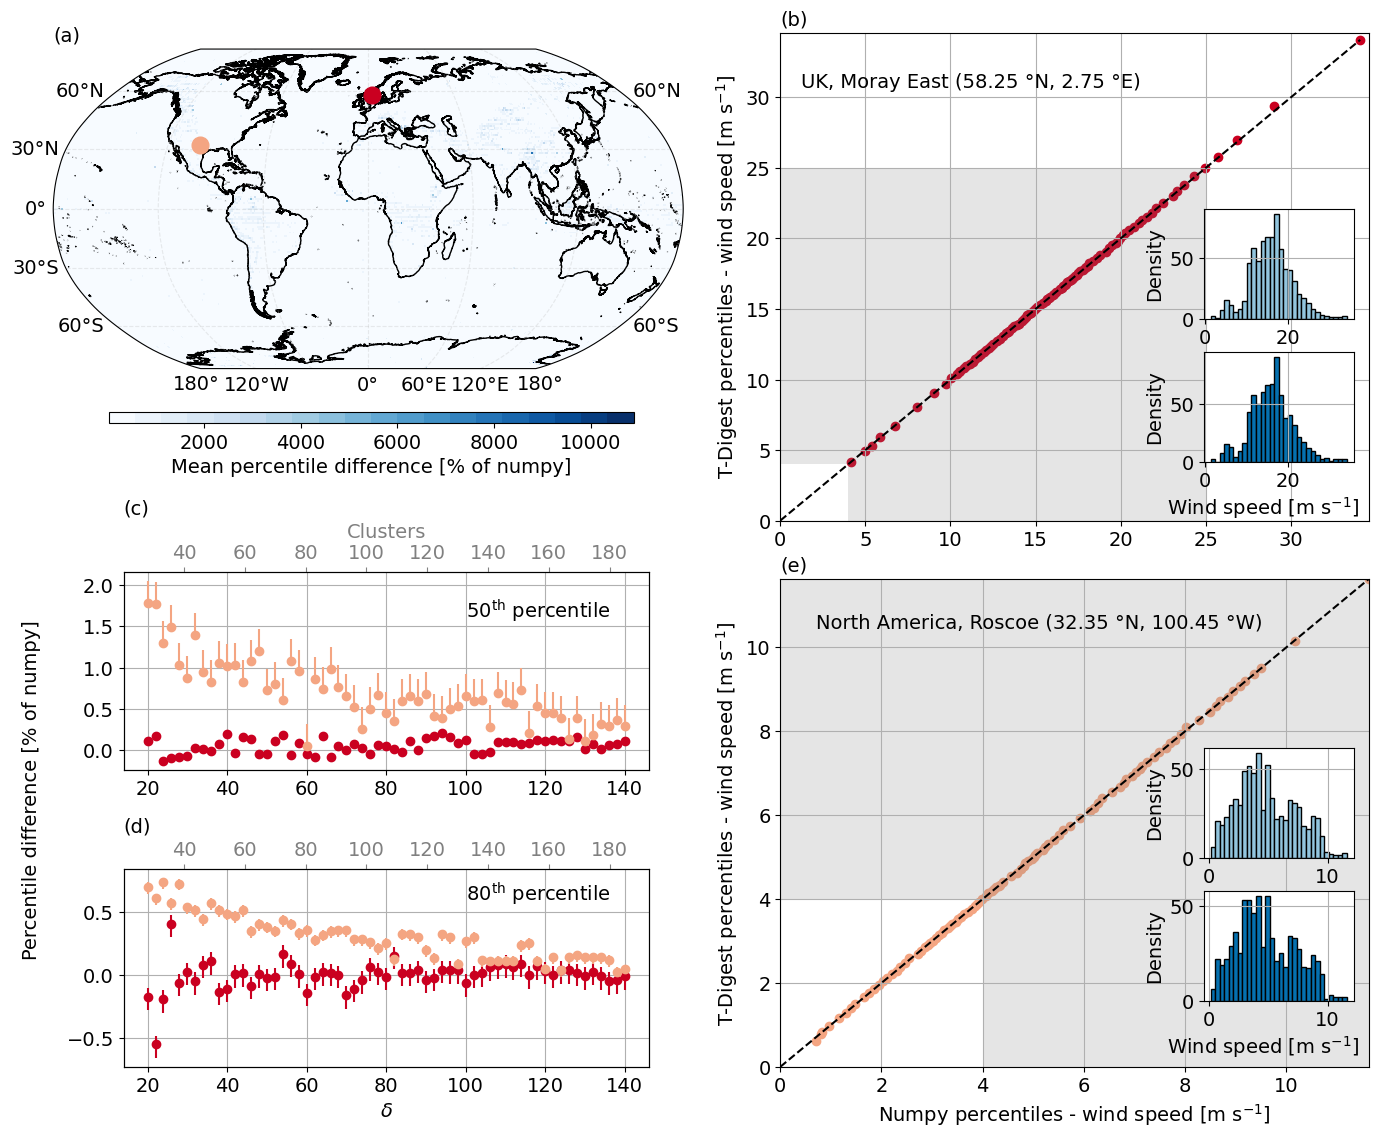

In [12]:
robinson = ccrs.Robinson()
geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(15,11))
fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.86, wspace = 0.5, hspace = 0.2)

nrow = 2
ncol = 2
outer = gs.GridSpec(nrow,ncol,wspace=0.2,hspace=0.12, width_ratios=[0.85, 0.8])

# fontsize
fsize = 14

# size of histogram inserts
ss_hist = 0.1
xp = 0.79

# compression factor for the histograms is 60 *array index is 20)
comp_index = 20

# defining colours for plotting
c1 = '#ca0020' 
c2 = '#f4a582'
c3 = '#92c5de' 
c4 = '#0571b0'

# setting the global map
# [left, bottom, width, height]
ax = fig.add_axes([0.023, 0.62, 0.42, 0.42], projection = robinson)

fig.subplots_adjust(bottom=0.05, top=0.99, left=0.01, right=0.9, wspace = 0.2, hspace = 0.4)
ax.coastlines(resolution = '10m')

#meridians and parallels
gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize}
gl.ylabel_style = {'size': fsize}

cmap = plt.get_cmap('Blues', 20)
lon2d, lat2d = np.meshgrid(ws.lon, ws.lat)
cs = ax.pcolormesh(lon2d, lat2d, total_per_error[0,:,:], transform=ccrs.PlateCarree(),cmap=cmap)

lon1 = ws.lon[target_index_uk_lon].values
lat1 = ws.lat[target_index_uk_lat].values

lon2 = ws.lon[target_index_texas_lon].values
lat2 = ws.lat[target_index_texas_lat].values

#Transform the coordinates of the rectangles to the projection coordinates
rect1 = robinson.transform_point(lon1, lat1, geodetic)
rect2 = robinson.transform_point(lon2, lat2, geodetic)

ax.plot(rect1[0], rect1[1], color=c1, marker='o', markersize=12,
        transform=robinson)
ax.plot(rect2[0], rect2[1], color=c2, marker='o', markersize=12,
    transform=robinson)
ax.set_title('(a)', fontsize = fsize, loc = 'left')

# Add color bar for each subplot
cbar_ax = fig.add_axes([0.06, 0.635, 0.35, 0.01])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
#cbar.set_ticks(cbar.get_ticks()[::-1])        
cbar.set_label('Mean percentile difference [% of numpy]', rotation=0, fontsize = fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.update_ticks()

# quantile quantile plot for the UK wind farm
percen_digest = np.zeros(100)
percen_np = np.zeros(100)
quantiles = np.linspace(1, 100, 100)
alpha = 0.2
# Create main scatter plot

ax = plt.subplot(outer[1])
ax.set_ylabel(r'T-Digest percentiles - wind speed [m s$^{-1}$]', fontsize = fsize)
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.grid(True)
ax.set_title('(b)', fontsize = fsize, loc = 'left')

# for each percentile extracting the TDigest and numpy estimate
for i in range(100):
    percen_digest[i] = tdigest_list_uk[comp_index].quantile(quantiles[i]/100)
    percen_np[i] = np.percentile(ws_uk, q = quantiles[i])

text_height = 0.9*np.max(percen_digest)
ax.text(1.2, text_height, 'UK, Moray East (58.25 °N, 2.75 °E)', fontsize = fsize)
ax.scatter(percen_np, percen_digest, color=c1)
# adding the x = y line 
x_values = np.linspace(0,np.max(ws_uk),100)
y_values = x_values
ax.plot(x_values, y_values, label='x = y', linestyle="--", color='black')

# adding gray patches to show range of wind farm operating speeds
x_start, x_end = 4, 25
y_bottom, y_top = 0, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)
x_start, x_end = 0, 4
y_bottom, y_top = 4, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)  
ax.set_xlim([0,np.max(percen_np)+0.5])      
ax.set_ylim([0,np.max(percen_digest)+0.5])
 
# adding the histograms
bins_space = 30
counts, bins = tdigest_list_uk[comp_index].histogram(bins_space)

# Create inset axes for the histogram
ax_hist2 = fig.add_axes([xp, 0.73, ss_hist, ss_hist])  # [left, bottom, width, height]
ax_hist2.hist(bins[:-1], bins=bins, weights=counts, color=c3, edgecolor='black', alpha=1)
ax_hist2.set_ylabel('Density', fontsize = fsize)
ax_hist2.tick_params('y', labelsize = fsize)
ax_hist2.tick_params('x', labelsize = fsize)
ax_hist2.grid(True)
            
#Create inset axes for the histogram
ax_hist = fig.add_axes([xp, 0.6, ss_hist, ss_hist])  # [left, bottom, width, height]
ax_hist.hist(ws_uk.flatten(), bins=bins, color=c4, edgecolor='black')
ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
ax_hist.xaxis.set_label_coords(0.4, -0.3)  
ax_hist.set_ylabel('Density', fontsize = fsize)
ax_hist.tick_params('y', labelsize = fsize)
ax_hist.tick_params('x', labelsize = fsize)
ax_hist.grid(True)
        
# quantile quantile plot for the Texas wind farm
ax = plt.subplot(outer[3])
percen_digest = np.zeros(100)
percen_np = np.zeros(100)

ax.set_xlabel(r'Numpy percentiles - wind speed [m s$^{-1}$]', fontsize = fsize)        
ax.set_ylabel(r'T-Digest percentiles - wind speed [m s$^{-1}$]', fontsize = fsize)
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.grid(True)
ax.set_xlim([0, np.max(ws_texas)])
ax.set_ylim([0, np.max(ws_texas)])
ax.set_title('(e)', fontsize = fsize, loc = 'left')

# extracting the TDigest and numpy percentile estimates
for i in range(100):
    percen_digest[i] = tdigest_list_texas[comp_index].quantile(quantiles[i]/100)
    percen_np[i] = np.percentile(ws_texas, q = quantiles[i])

ax.scatter(percen_np, percen_digest, color=c2)
text_height = 0.9*np.max(percen_digest)
ax.text(0.7, text_height, 'North America, Roscoe (32.35 °N, 100.45 °W)', fontsize = fsize)

# adding x = y line
ax.plot(x_values, y_values, label='x = y', linestyle="--", color='black')

# adding gray patches to show range of wind farm operating speeds
x_start, x_end = 4, 25
y_bottom, y_top = 0, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)

x_start, x_end = 0, 4
y_bottom, y_top = 4, 25
rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                            linewidth=1, edgecolor='None', facecolor='gray', 
                            alpha=alpha)
ax.add_patch(rectangle)

counts, bins = tdigest_list_texas[comp_index].histogram(bins_space)

# Create inset axes for the histogram
ax_hist2 = fig.add_axes([xp, 0.24, ss_hist, ss_hist])  # [left, bottom, width, height]
ax_hist2.hist(bins[:-1], bins=bins, weights=counts, color = c3, edgecolor='black', alpha = 1)
ax_hist2.set_ylabel('Density', fontsize = fsize)
ax_hist2.tick_params('y', labelsize = fsize)
ax_hist2.tick_params('x', labelsize = fsize)
ax_hist2.grid(True)

#Create inset axes for the histogram
ax_hist = fig.add_axes([xp, 0.11, ss_hist, ss_hist])  # [left, bottom, width, height]
ax_hist.hist(ws_texas.flatten(), bins=bins, color=c4, edgecolor='black')
ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
ax_hist.xaxis.set_label_coords(0.4, -0.3)  
ax_hist.set_ylabel('Density', fontsize = fsize)
ax_hist.tick_params('y', labelsize = fsize)
ax_hist.tick_params('x', labelsize = fsize)
ax_hist.grid(True)
       
# 50th and 80th percentile errors as a function of compression
# factors to get the correct location
ss = 0.175
extra = 0.005

ax = fig.add_axes([0.07, 0.32, ss*2, ss+extra])  # [left, bottom, width, height]
ax.errorbar(compressions, errors_p[0, :,0], yerr = errors_bars_p[0:2, :,0], marker = 'o', color=c1,linestyle='')
ax.errorbar(compressions, errors_p[1, :,0], yerr = errors_bars_p[2:4, :,0], marker = 'o', color=c2,linestyle='')
obh = ax.set_ylabel('Percentile difference [% of numpy]', fontsize = fsize, labelpad = 30)
obh.set_position((0, -0.1))  # Adjust the position tuple as needed

ax.grid(True)
text_height = 0.9*np.max(errors_p[1, :, 0])
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.text(100, text_height, r'50$^{\text{th}}$ percentile', fontsize = fsize)
ax.set_title('(c)', fontsize = fsize, loc = 'left')
#Create a second x-axis sharing the same x-axis
ax2 = ax.twiny()
ax2.scatter(centriod_num_uk[:,0], errors[0,:,0], color='gray', marker = '')
ax2.set_xlabel('Clusters', color='gray', fontsize = fsize)
ax2.tick_params('x', colors='gray', labelsize = fsize)

text_height = 0.8*np.max(errors_p[1, :, 1])
ax = fig.add_axes([0.07, 0.05, ss*2, ss+extra])  # [left, bottom, width, height]
ax.errorbar(compressions, errors_p[0, :, 1], yerr = errors_bars_p[0:2, :,1], marker = 'o', color=c1,linestyle='')
ax.errorbar(compressions, errors_p[1, :, 1], yerr = errors_bars_p[2:4, :,1]*2, marker = 'o', color=c2,linestyle='')
ax.tick_params('y', labelsize = fsize)
ax.tick_params('x', labelsize = fsize)
ax.text(100, text_height, r'80$^{\text{th}}$ percentile', fontsize = fsize)
ax.set_xlabel(r'$\delta$', fontsize = fsize)
ax.grid(True)
ax.set_title('(d)', fontsize = fsize, loc = 'left')
ax2 = ax.twiny()
ax2.scatter(centriod_num_uk[:,0], errors[0,:,0], color='gray', marker = '')
ax2.tick_params('x', colors='gray', labelsize = fsize)
                
plt.show()